<a href="https://colab.research.google.com/github/YichengShen/segment-anything/blob/main/testing/sam-ksdd2/SAM-KSDD2%E5%BE%AE%E8%B0%83%EF%BC%88%E8%AE%AD%E7%BB%83%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 用KSDD2数据集微调SAM

## 环境设置

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q monai

In [ ]:
import cv2
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

## KSDD2数据集

### 下载数据集

In [ ]:
if not os.path.exists('data'):
    !wget -O ksdd.zip https://go.vicos.si/kolektorsdd2
    !mkdir data
    !unzip -q /content/ksdd.zip -d /content/data
    !rm /content/ksdd.zip

### 筛选数据

KSDD2的训练集中包含缺陷的图片有246张和不包含缺陷的图片有2085张，测试集中包含缺陷的图片有110张和不包含缺陷的图片有894张。

我们只使用包含缺陷的图片。

In [ ]:
def filter_data(folder):
    all_files = os.listdir(folder)
    mask_files = [f for f in all_files if f.endswith('_GT.png')]

    filtered = []
    for mask_file in mask_files:
        mask = cv2.imread(os.path.join(folder, mask_file), cv2.IMREAD_UNCHANGED)
        if mask is not None and not np.all(mask == 0):
            original_file = mask_file.replace('_GT', '')
            filtered.append((original_file, mask_file))

    return filtered

folder = "/content/data/train"
files = filter_data(folder)

# 分成80%训练集和20%验证集
train_files, validation_files = train_test_split(files, test_size=0.20)
print("训练集:", len(train_files))
print("验证集:", len(validation_files))

test_folder = "/content/data/test"
test_files = filter_data(test_folder)
print("测试集：", len(test_files))

训练集: 196
验证集: 50
测试集： 110


### 可视化一张图片

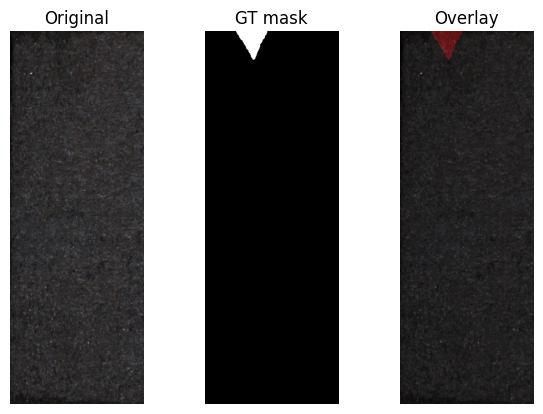

In [ ]:
folder_path = "/content/data/train"
image_fname = train_files[6][0]
ground_truth_fname = train_files[6][1]

plt.figure(figsize=(6,12))

image = cv2.imread(os.path.join(folder_path, image_fname))
ground_truth = cv2.imread(os.path.join(folder_path, ground_truth_fname), cv2.IMREAD_GRAYSCALE)

# 原图
plt.subplot(3, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original")
plt.axis('off')

# 掩码 ground truth
plt.subplot(3, 3, 2)
plt.imshow(ground_truth, cmap='gray')
plt.title("GT mask")
plt.axis('off')

# 在原图上展示掩码
plt.subplot(3, 3, 3)
_, binary_mask = cv2.threshold(ground_truth, 127, 255, cv2.THRESH_BINARY)
overlay = np.zeros_like(image)
overlay[binary_mask == 255] = [255, 0, 0] # 红色
output = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)
plt.imshow(output, cmap='gray')
plt.title("Overlay")
plt.axis('off')


plt.tight_layout()
plt.show()

## 准备数据

### 根据掩码取边界框

In [ ]:
def get_bounding_box(ground_truth_map):
  # 根据掩码取边界框
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # 给框加一些干扰值
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 10))
  x_max = min(W, x_max + np.random.randint(0, 10))
  y_min = max(0, y_min - np.random.randint(0, 10))
  y_max = min(H, y_max + np.random.randint(0, 10))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

在图片上展示边界框

[50, 0, 109, 51]


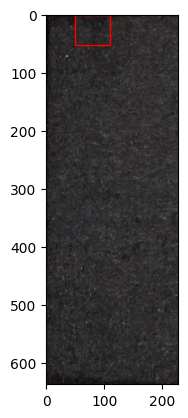

In [ ]:
import matplotlib.patches as patches

bbox = get_bounding_box(ground_truth)
print(bbox)

fig, ax = plt.subplots(1)
ax.imshow(image, cmap='gray')

rect = patches.Rectangle((bbox[0],bbox[1]),(bbox[2]-bbox[0]),(bbox[3]-bbox[1]),
                         linewidth=1,
                         edgecolor='r',
                         facecolor='none')

ax.add_patch(rect)

plt.show()

### 定义PyTorch Dataset

In [ ]:
from torch.utils.data import Dataset


class KSDD2Dataset(Dataset):
    def __init__(self, folder, files, processor, image_size=(256, 256), num_samples=None):
        self.folder = folder
        self.processor = processor
        self.files = files

        if num_samples is not None:
            self.files = random.sample(self.files, num_samples)

        self.image_size = image_size

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.folder, self.files[idx][0])
        mask_path = os.path.join(self.folder, self.files[idx][1])
        image = cv2.imread(image_path)
        ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, self.image_size)
        ground_truth_mask = cv2.resize(ground_truth_mask, self.image_size)

        prompt = get_bounding_box(ground_truth_mask)

        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [ ]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [ ]:
folder = "/content/data/train"
train_dataset = KSDD2Dataset(folder=folder,
                             files=train_files,
                             processor=processor)
validation_dataset = KSDD2Dataset(folder=folder,
                                  files=validation_files,
                                  processor=processor)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)
print("\n")
example = validation_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


### 定义PyTorch DataLoader



In [ ]:
from torch.utils.data import DataLoader

batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)
print("\n")
batch = next(iter(validation_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([4, 3, 1024, 1024])
original_sizes torch.Size([4, 2])
reshaped_input_sizes torch.Size([4, 2])
input_boxes torch.Size([4, 1, 4])
ground_truth_mask torch.Size([4, 256, 256])


pixel_values torch.Size([4, 3, 1024, 1024])
original_sizes torch.Size([4, 2])
reshaped_input_sizes torch.Size([4, 2])
input_boxes torch.Size([4, 1, 4])
ground_truth_mask torch.Size([4, 256, 256])


In [ ]:
batch["ground_truth_mask"].shape

torch.Size([4, 256, 256])

## 加载SAM模型

In [ ]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# 只更新掩码解码器
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

## 训练

In [ ]:
num_epochs = 30
lr = 1e-5
weight_decay = 1e-5

In [ ]:
from datetime import datetime
import csv

fname_suffix = f"{lr}_{weight_decay}"

# 根据现在的时间创建文件夹
now = datetime.now()
timestamp_str = now.strftime("%Y%m%d_%H%M%S")
folder_path = f"/content/drive/Shareddrives/SAM调研/SAM/SAM微调/{timestamp_str}_{fname_suffix}"
os.makedirs(folder_path, exist_ok=True)

# log文件名
log_fname = f"log_{fname_suffix}.csv"
log_path = os.path.join(folder_path, log_fname)
with open(log_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["EPOCH", "Training Mean loss", "Validation Mean loss", "Test mIoU"])

计算mIoU的辅助函数

In [ ]:
def get_iou(folder, files, device):
    iou = []
    for idx in range(len(test_files)):
        image_path = os.path.join(folder, files[idx][0])
        mask_path = os.path.join(folder, files[idx][1])
        image = cv2.imread(image_path)
        ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        prompt = get_bounding_box(ground_truth_mask)
        inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)

        iou.append(np.max(outputs.iou_scores.cpu().numpy()))

    return np.mean(iou)

In [ ]:
from torch.optim import Adam
import monai

optimizer = Adam(model.mask_decoder.parameters(), lr=lr, weight_decay=weight_decay)

seg_loss = monai.losses.DiceCELoss(sigmoid=False, squared_pred=True, reduction='mean')

训练

In [ ]:
from tqdm import tqdm
from statistics import mean

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_dataloader):
      # Forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # Compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # Backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # Optimize
      optimizer.step()
      train_losses.append(loss.item())

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in tqdm(validation_dataloader):
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

            val_losses.append(loss.item())

    # Compute Intersection over Union (IoU) for test data
    test_iou = get_iou(test_folder, test_files, device)

    print(f'EPOCH: {epoch} | Training loss: {mean(train_losses):.4f} | Validation loss: {mean(val_losses):.4f} | Test mIoU: {test_iou:.4f}')

    # Log
    with open(log_path, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch, mean(train_losses), mean(val_losses), test_iou])

    # Save model checkpoint every 5 epochs
    if (epoch+1) % 2 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f'{folder_path}/checkpoint_{epoch+1}_{lr}_{weight_decay}.pth')

100%|██████████| 13/13 [00:24<00:00,  1.86s/it]


EPOCH: 0 | Training loss: 0.8550 | Validation loss: 0.5539 | Test mIoU: 0.9422


100%|██████████| 13/13 [00:24<00:00,  1.86s/it]


EPOCH: 1 | Training loss: 0.2955 | Validation loss: 0.2511 | Test mIoU: 0.9561


100%|██████████| 13/13 [00:24<00:00,  1.88s/it]


EPOCH: 2 | Training loss: 0.1792 | Validation loss: 0.2174 | Test mIoU: 0.9603


100%|██████████| 13/13 [00:24<00:00,  1.88s/it]


EPOCH: 3 | Training loss: 0.1603 | Validation loss: 0.2088 | Test mIoU: 0.9604


100%|██████████| 13/13 [00:24<00:00,  1.87s/it]


EPOCH: 4 | Training loss: 0.1445 | Validation loss: 0.1962 | Test mIoU: 0.9600


100%|██████████| 13/13 [00:24<00:00,  1.86s/it]


EPOCH: 5 | Training loss: 0.1341 | Validation loss: 0.2009 | Test mIoU: 0.9566


100%|██████████| 13/13 [00:24<00:00,  1.88s/it]


EPOCH: 6 | Training loss: 0.1281 | Validation loss: 0.1859 | Test mIoU: 0.9588


100%|██████████| 13/13 [00:24<00:00,  1.87s/it]


EPOCH: 7 | Training loss: 0.1255 | Validation loss: 0.1889 | Test mIoU: 0.9594


100%|██████████| 13/13 [00:24<00:00,  1.85s/it]


EPOCH: 8 | Training loss: 0.1187 | Validation loss: 0.1985 | Test mIoU: 0.9578


100%|██████████| 13/13 [00:24<00:00,  1.86s/it]


EPOCH: 9 | Training loss: 0.1157 | Validation loss: 0.1825 | Test mIoU: 0.9577


100%|██████████| 13/13 [00:24<00:00,  1.86s/it]


EPOCH: 10 | Training loss: 0.1106 | Validation loss: 0.1842 | Test mIoU: 0.9603


100%|██████████| 13/13 [00:24<00:00,  1.87s/it]


EPOCH: 11 | Training loss: 0.1107 | Validation loss: 0.1990 | Test mIoU: 0.9581


100%|██████████| 13/13 [00:24<00:00,  1.87s/it]


EPOCH: 12 | Training loss: 0.1123 | Validation loss: 0.1834 | Test mIoU: 0.9595


100%|██████████| 13/13 [00:24<00:00,  1.87s/it]


EPOCH: 13 | Training loss: 0.1077 | Validation loss: 0.1794 | Test mIoU: 0.9604


100%|██████████| 13/13 [00:24<00:00,  1.86s/it]


EPOCH: 14 | Training loss: 0.1024 | Validation loss: 0.1875 | Test mIoU: 0.9620


100%|██████████| 13/13 [00:24<00:00,  1.88s/it]


EPOCH: 15 | Training loss: 0.1014 | Validation loss: 0.1851 | Test mIoU: 0.9601


100%|██████████| 13/13 [00:24<00:00,  1.87s/it]


EPOCH: 16 | Training loss: 0.1025 | Validation loss: 0.1867 | Test mIoU: 0.9612


100%|██████████| 13/13 [00:24<00:00,  1.87s/it]


EPOCH: 17 | Training loss: 0.0998 | Validation loss: 0.1885 | Test mIoU: 0.9613


100%|██████████| 13/13 [00:24<00:00,  1.85s/it]


EPOCH: 18 | Training loss: 0.0955 | Validation loss: 0.1843 | Test mIoU: 0.9609


100%|██████████| 13/13 [00:24<00:00,  1.85s/it]


EPOCH: 19 | Training loss: 0.0948 | Validation loss: 0.1894 | Test mIoU: 0.9617


100%|██████████| 13/13 [00:24<00:00,  1.86s/it]


EPOCH: 20 | Training loss: 0.0961 | Validation loss: 0.1846 | Test mIoU: 0.9605


100%|██████████| 13/13 [00:24<00:00,  1.85s/it]


EPOCH: 21 | Training loss: 0.0935 | Validation loss: 0.2035 | Test mIoU: 0.9609


100%|██████████| 13/13 [00:24<00:00,  1.86s/it]


EPOCH: 22 | Training loss: 0.0937 | Validation loss: 0.1875 | Test mIoU: 0.9593


100%|██████████| 13/13 [00:24<00:00,  1.88s/it]


EPOCH: 23 | Training loss: 0.0916 | Validation loss: 0.1812 | Test mIoU: 0.9620


100%|██████████| 13/13 [00:24<00:00,  1.87s/it]


EPOCH: 24 | Training loss: 0.0874 | Validation loss: 0.1785 | Test mIoU: 0.9615


100%|██████████| 13/13 [00:24<00:00,  1.86s/it]


EPOCH: 25 | Training loss: 0.0892 | Validation loss: 0.1906 | Test mIoU: 0.9613


100%|██████████| 13/13 [00:24<00:00,  1.88s/it]


EPOCH: 26 | Training loss: 0.0857 | Validation loss: 0.1809 | Test mIoU: 0.9609


100%|██████████| 13/13 [00:24<00:00,  1.87s/it]


EPOCH: 27 | Training loss: 0.0871 | Validation loss: 0.1835 | Test mIoU: 0.9604


100%|██████████| 13/13 [00:24<00:00,  1.86s/it]


EPOCH: 28 | Training loss: 0.0866 | Validation loss: 0.1793 | Test mIoU: 0.9598


100%|██████████| 13/13 [00:24<00:00,  1.86s/it]


EPOCH: 29 | Training loss: 0.0856 | Validation loss: 0.1848 | Test mIoU: 0.9597


## mIoU对比

In [ ]:
test_folder = "/content/data/test"

iou_finetune = []
# iou_without_finetune = []

for idx in range(len(test_files)):
    image_path = os.path.join(test_folder, test_files[idx][0])
    mask_path = os.path.join(test_folder, test_files[idx][1])
    image = cv2.imread(image_path)
    ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    prompt = get_bounding_box(ground_truth_mask)
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        # outputs_without_finetune = model_without_finetune(**inputs)

    iou_finetune.append(np.max(outputs.iou_scores.cpu().numpy()))
    # iou_without_finetune.append(np.max(outputs_without_finetune.iou_scores.cpu().numpy()))


In [ ]:
# print("微调前的平均IoU：", np.mean(iou_without_finetune))
print("微调后的平均IoU：", np.mean(iou_finetune))

微调后的平均IoU： 0.94911414


## 预测

###辅助函数

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(10, 10))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

### 用测试集的图片测试效果

In [ ]:
test_folder = "/content/data/test"

# 随便取一个测试集的数据
idx = 96
print(test_files[idx])

image_path = os.path.join(test_folder, test_files[idx][0])
mask_path = os.path.join(test_folder, test_files[idx][1])

image = cv2.imread(image_path)
ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# 计算边界框作为提示
prompt = get_bounding_box(ground_truth_mask)

inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)

# 预测
model.eval()
with torch.no_grad():
    # outputs = model(**inputs, multimask_output=False)
    outputs = model(**inputs)

output_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)

show_masks_on_image(image, output_masks[0], outputs.iou_scores)

和GT掩码对比


In [ ]:
best_mask_idx = np.argmax(outputs.iou_scores.cpu().numpy())
best_mask = output_masks[0][0][best_mask_idx]

In [ ]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(np.array(image))
show_mask(best_mask, axes[0])
axes[0].set_title("Best predicted mask")
axes[0].axis("off")

axes[1].imshow(np.array(image))
show_mask(ground_truth_mask, axes[1])
axes[1].set_title("Ground truth mask")
axes[1].axis("off")

plt.show()

### 和没有微调的模型对比

In [ ]:
model_without_finetune = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)

model_without_finetune.eval()
with torch.no_grad():
    outputs_without_finetune = model_without_finetune(**inputs)

output_masks_without_finetune = processor.image_processor.post_process_masks(
    outputs_without_finetune.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)

show_masks_on_image(image, output_masks_without_finetune[0], outputs_without_finetune.iou_scores)

清理GPU RAM

In [ ]:
import gc

def garbage_collect():
    torch.cuda.empty_cache()
    gc.collect()

garbage_collect()

In [ ]:
!nvidia-smi

Sun Jun 25 18:26:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    39W /  70W |   2323MiB / 15360MiB |     56%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------